# Collaborative Filtering
This project will help you familiarize with the standard data science toolkits: Numpy, Pandas for data processing and Matplotlib / Seaborn for visualization, with a focus on Numpy and Pandas. On a more conceptual level, we will be looking at how a data science problem can be represented in different ways and tackled from different perspectives.

You are encouraged to consult the NumPy documentation and Pandas documentation while working on this project. Both libraries offer many useful built-in functions that can speed up your code.

In [2]:
# import library modules
from collections import defaultdict, Counter
from scipy.sparse import csr_matrix, coo_matrix, csc_matrix

import sys
import argparse
import copy
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg as la
import seaborn as sns
import matplotlib.pyplot as plt

## Dataset Overview
You, as a member of a high-performing data science team, have been tasked with developing a movie recommendation system. Given a set of user-data and movie-data, you are tasked with predicting user ratings on potentially unknown movies.

As you have no initial datasets to work with from the team, you will be working with a movie rating dataset from the MovieLens website (http://movielens.org). Specifically, you have chosen to use the **100K Dataset** which has 100,000 ratings from 943 users on 1682 movies.

Please visit the [README](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt) webpage to get detailed descriptions about the files in the dataset -- their content and format.

For this project, we will use two files:
* `u.data`: contains the user_id, item_id, rating score and timestamp of each review.
* `u.item`: contains metadata about the movies.

These files can be found in the handout directory `ml-100k`.

Take a look at the online README to familiarize yourself with the format of the data in these files. **Note that the `item_id` column in `u.data` corresponds to the `movie_id` column in `u.item`**.

In [3]:
# load the user-ratings data
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# load the movie metadata
columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL',
           'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
           'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
           'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

genres = columns[ columns.index('Action'):]
movies = pd.read_csv('ml-100k/u.item', sep='|', names=columns, index_col='movie_id', encoding="ISO-8859-1")

In [4]:
# note: this cell has been tagged with excluded_from_script.
# you do not need to remove it when submitting your notebook.
print("Ratings data")
display(ratings.head())

print("Movie data")
display(movies.head())

Ratings data


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Movie data


,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


**Note:** as you use Pandas to work with dataframes, keep in mind that most Pandas operations return a new dataframe instead of modifying the caller dataframe. To get the latter behavior, you can either reassign the caller dataframe to the return value of the function, or look for the option `inplace = True` while calling the function.


## Part A: Data Exploration and Visualization
---



Before developing a model, it is vitally important to spend time critically examining the dataset you are given. Developing effective machine learning models requires careful specification of the problem statement.

As we are developing a recommender system, a good first step for this dataset will be to answer the following questions:

*   How many movies does a particular user rate?
*   How many users rate a particular movie?
*   How do ratings evolve over time?

As we are interested in how to better serve recommendations of important content to users, the first two questions allow us to examine how many data points we have connecting movies to users and users to movies. As production systems have no knowledge of future user ratings, the third question allows us to understand how we might want to assess problem performance.

### Question 1: Average movie rating and count per user

First, we will investigate the distribution of movie ratings per user. Complete the function `movie_rating_by_user` to return a nested dictionary having the following structure:
```
{
    196: {'average': 3.4, 'count': 10}
    128: {'average': 1.2, 'count': 12}
}
```
  
where the outer key is a user_id, the inner keys are 'average' and 'count', and their values are either the **average** or **number** of movie ratings the user has.

**Notes**:
* If a user reviews the same movie multiple times, only consider the latest rating.
* Be careful when converting from a dataframe to a dictionary. The [to_dict](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html) method may be useful.
* When manipulating your dataframe, if you use a groupby, you should pay ample attention to the index, and potentially call `reset_index`.


In [5]:
def movie_rating_by_user(ratings):
    """
    Calculate the average and number of movie ratings for each user.

    args:
        ratings (pd.DataFrame) : DataFrame containing rating data

    return:
        Dict[int, Dict[str, int]]  : a nested mapping from user id to 'average' and 'count' and to their appropriate values.
        
        Example:
        {1: {'average': 3.610294117647059, 'count': 272},
         2: {'average': 3.7096774193548385, 'count': 62},
         ...}
    """
    # TODO: Sort the DataFrame by user_id and item_id in ascending order.
    df_sorted = ratings.sort_values(['user_id', 'item_id'])
    
    # TODO: Remove duplicate ratings per user-item pair, keeping only the most recent entry.
    df_clean = (df_sorted.sort_values("timestamp", ascending=False).drop_duplicates(subset=["user_id", "item_id"], keep="first"))
    df_clean_sorted = df_clean.sort_values(['user_id', 'item_id'])

    # Group the data by user_id and calculate the required statistics.
    average_rating_per_user = df_clean_sorted.groupby('user_id')['rating'].mean()
    rating_count_per_user = df_clean_sorted.groupby('user_id').size()
    #print(average_rating_per_user)

    # Rename the aggregated columns to match the required output.
    # TODO: Rename columns to 'average' and 'count'.
    average_and_count_df = pd.concat([average_rating_per_user, rating_count_per_user], axis = 1)
    average_and_count_df.columns = ['average', 'count']
    
    # Format the result into a nested dictionary.
    # TODO: Convert the resulting DataFrame to the specified dictionary format.
    user_stats_dict = average_and_count_df.to_dict(orient="index")


    # Return the processed results.
    return user_stats_dict

In [6]:
# local test
def test_movie_rating_by_user():
   ratings_per_user = movie_rating_by_user(ratings)
   assert len(ratings_per_user) == 943
   assert sum(elem['count'] for _, elem in ratings_per_user.items()) == 100000,  sum(elem['count'] for _, elem in ratings_per_user.items())
   assert ratings_per_user[1]['count'] == 272, ratings_per_user[1]['count']
   assert ratings_per_user[1]['average'] == 3.610294117647059, ratings_per_user[1]['average']
   print("All tests passed!")

test_movie_rating_by_user()

All tests passed!


Now that you have a working aggregation function, let's plot the results for our own analysis:

[Text(0.5, 0, 'average')]

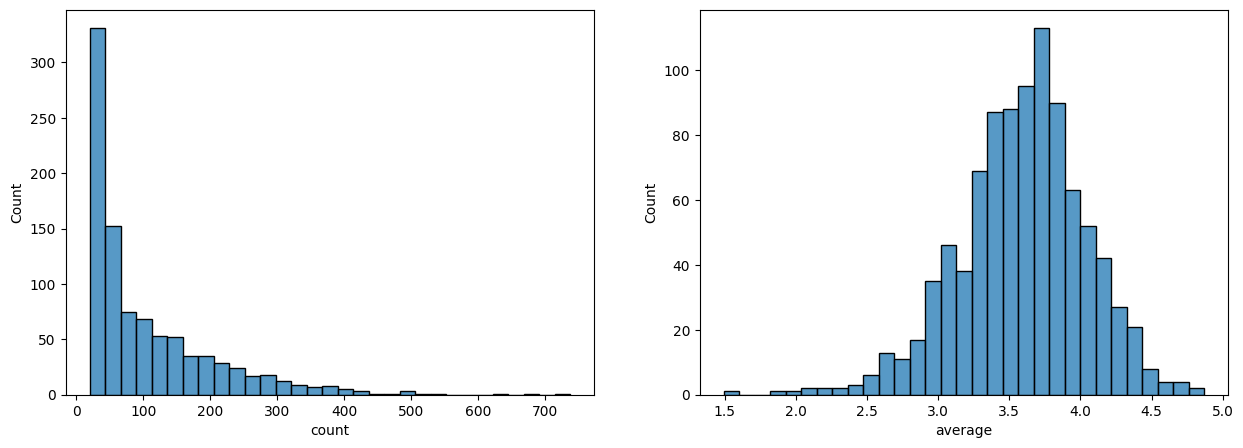

In [7]:
# calculate the average and number of ratings per user
ratings_per_user = movie_rating_by_user(ratings)

# plot the histograms
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(data=[elem['count'] for _, elem in ratings_per_user.items()], ax=axes[0])
axes[0].set(xlabel='count')
sns.histplot(data=[elem['average'] for _, elem in ratings_per_user.items()], ax=axes[1])
axes[1].set(xlabel='average')

From the above graph, we see that the rating count follows an exponential curve, where there are a few users which rate a large amount of movies, and a majority of users rate only a few movies. Conversely, the rating average follows a normal distribution, with the majority of ratings users give are greater than 3. This suggests that the users of this dataset generally give positive reviews, and that it might be harder to get users to give negative reviews.

### Question 2: Movie count over time
Next, we will investigate how the number of movies released has changed over time. As a recommender system is frequently measured by live performance, it is traditional to see if past data can achieve good performance on future data. Complete the function movie_count_by_month to return a nested dictionary having the following structure:

```
{
    1922: { 'May': 1, 'June': 2, ...},
    1923: { 'January': 3, ...},
    ...
}
```
where the outer key is a year, the inner key is a month name and the value is the number of movies released in that month.

Notes:

* The outer keys (years) are integers, while the inner keys (months) are strings.
* Use pandas.datetime to process dates appropriately. You'll need to specify the format appropriately in order to accurately extract the dates - the documentation [here](https://docs.python.org/3/library/datetime.html) should help.
* If there are no movies related in a certain month in a year, that year should not be included in the inner dictionary.
* If a time cannot be converted to datetime, ignore it entirely from this analysis.

In [8]:
def movie_count_by_month(movies):
    """
    Count the number of movies in each month

    args:
        movies (pd.DataFrame) : Dataframe containing movie attributes

    return:
        Dict[int, Dict[str, int]]  : a nested mapping from year to month to number of movies in that month
    """
    # Create a copy of the DataFrame to avoid modifying the original.
    movies = copy.deepcopy(movies)

    # Initialize a nested dictionary to store counts.
    month_counts = defaultdict(lambda: defaultdict(int))

    # TODO: Convert the 'release_date' column to datetime format and drop rows with missing dates.
    movies['release_date'] = pd.to_datetime(movies['release_date'])
    movies = movies.dropna(subset=['release_date'])
    
    # TODO: Iterate through the movies DataFrame to populate the month_counts dictionary.
    for _, movie in movies.iterrows():
        # Extract the year and month from the release date.
        year = movie['release_date'].year
        month = movie['release_date'].month_name()
        
        # Increment the count for the respective year and month.
        month_counts[year][month] += 1

    #For self -- sort the nested dictionary.  Note that month names will be sorted alphabetically (no key provided)
    sorted_inner = {outer_key: dict(sorted(inner_dict.items())) for outer_key, inner_dict in month_counts.items()}
    month_counts = dict(sorted(sorted_inner.items()))

    # Return the resulting nested dictionary.
    return month_counts


In [9]:
# local test
def test_movie_count_by_month():
    genre_count = movie_count_by_month(movies)
    assert sorted(genre_count.keys())[:5] == [1922,1926,1930, 1931,1932]
    assert sorted(genre_count.keys())[-5:] == [1994, 1995, 1996, 1997, 1998]
    assert genre_count[1922]['January'] == 1
    assert genre_count[1998]['January'] == 30
    print("All tests passed!")

test_movie_count_by_month()

All tests passed!


Now let's try to see how the number of movies released has changed over time.

**Note** Pay special attention to the data types you are returning. Pandas likes to use decimals, whereas we want to use integers.

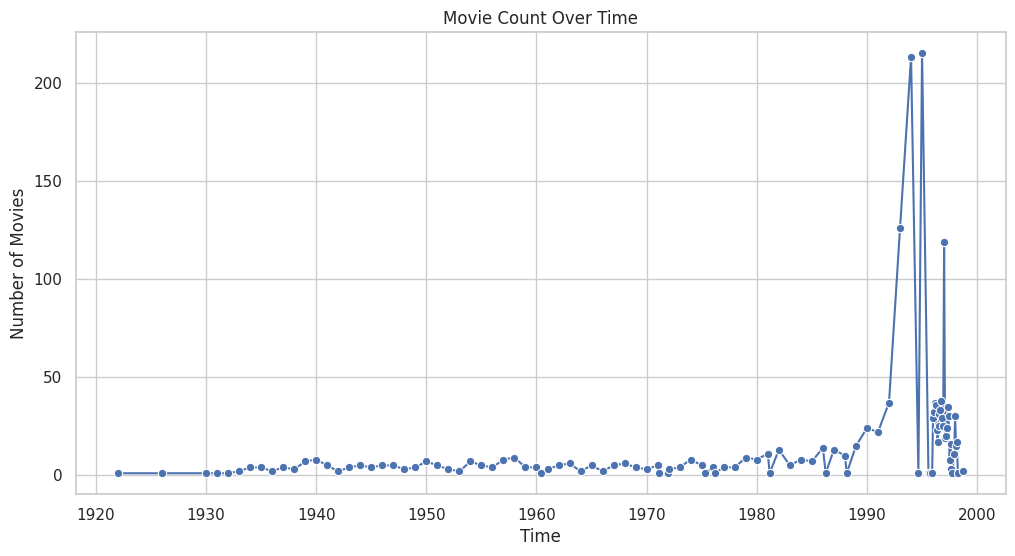

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_movie_count():
    sns.set(style="whitegrid")

    movie_counts_dict = movie_count_by_month(movies)

    data = []

    for year, month_data in movie_counts_dict.items():
        for month, count in month_data.items():
            data.append({'Year': year, 'Month': month, 'Count': count})

    plot_data = pd.DataFrame(data)

    plot_data['release_date'] = pd.to_datetime(plot_data['Year'].astype(str) + '-' + plot_data['Month'].astype(str), format='%Y-%B')

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=plot_data, x='release_date', y='Count', marker='o')

    plt.title('Movie Count Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Movies')

    plt.show()

plot_movie_count()


From the above graph, we see that, in terms of movie rating counts, our data is heavily skewed to more recent films. We should expect that our ratings follows a similar trend.

### Question 3: Movie ratings over time
The quantity of movie ratings has certainly increased over time, but is the quality of movies improving as well? We can plot the distribution of ratings in recent months to find out.

Complete the function `movie_rating_distribution` which returns a dataframe that contains the review date and average user rating, averaged per day. The index of the dataframe should be the review date, `date` (a datetime object), and there should be one column, labelled `rating`, which consists of the average user rating on that day.

Here is a sample of the output you should expect:

```
1997-09-20 00:00:00	3.746448
1997-09-21 00:00:00	3.552727
1997-09-22 00:00:00	3.175676
1997-09-23 00:00:00	3.670984
1997-09-24 00:00:00	3.445230
```

**Notes**:
1. Be careful when converting timestamps to datetime objects. Pay careful attention to the unit argument, and [check the Pandas documentation for more information](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)
1. Do not worry about duplicated reviews for the same movie by the same user for this question.
1. Do not use a date object, but a datetime object for `date`.
1. Sort the dataframe by the index before returning the dataframe in chronological order.

In [11]:
def movie_rating_distribution(ratings):
    """
    Aggregate the average rating per day, and release a DataFrame of the data appropriately.

    args:
        ratings (pd.DataFrame)  : DataFrame containing user ratings

    return:
        pd.DataFrame  : a DataFrame of the review dates and ratings
    """
    # Create a copy of the ratings DataFrame to preserve the original.
    ratings = copy.deepcopy(ratings)
    
    # Convert the 'timestamp' column to datetime.
    # TODO: Use the appropriate unit for timestamp conversion (e.g., seconds, milliseconds).
    ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
    # Extract the relevant date components from the 'timestamp'.
    ratings['year'] = ratings['timestamp'].dt.year   # TODO: Extract the year from the timestamp.
    ratings['month'] = ratings['timestamp'].dt.month  # TODO: Extract the month from the timestamp.
    ratings['day'] = ratings['timestamp'].dt.day    # TODO: Extract the day from the timestamp.

    # Group by year, month, and day, then calculate the average rating.
    # TODO: Replace the ellipses with appropriate group-by columns and aggregation logic.
    ratings = ratings.groupby([ratings['year'], ratings['month'], ratings['day']]).mean().reset_index()

    # Create a new column for the full date.
    # TODO: Ensure the date format is correct during conversion.
    # Combine year, month, and day into a single string formatted as 'YYYY-MM-DD'.
    date_strings = ratings[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1)
    
    # Convert the combined strings into datetime objects with the specified format.
    ratings['date'] = pd.to_datetime(date_strings, format='%Y-%m-%d')
    
    # Set the date as the index and sort the DataFrame.
    ratings = ratings.set_index('date')
    ratings.drop(columns=['year', 'month', 'day', 'user_id', 'item_id', 'timestamp'], inplace=True)
    ratings.sort_index(inplace=True)
    
    # Return the processed DataFrame.
    return ratings


In [12]:
# local test
def test_movie_rating_distribution():
    ratings_dist = movie_rating_distribution(ratings)
    assert ratings_dist.shape == (213,1)
    assert ratings_dist['rating'][0] == 3.746448087431694
    assert ratings_dist['rating'][100] == 3.482
    print("All tests passed!")

test_movie_rating_distribution()

All tests passed!


/tmp/ipykernel_29905/222530243.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert ratings_dist['rating'][0] == 3.746448087431694
/tmp/ipykernel_29905/222530243.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert ratings_dist['rating'][100] == 3.482


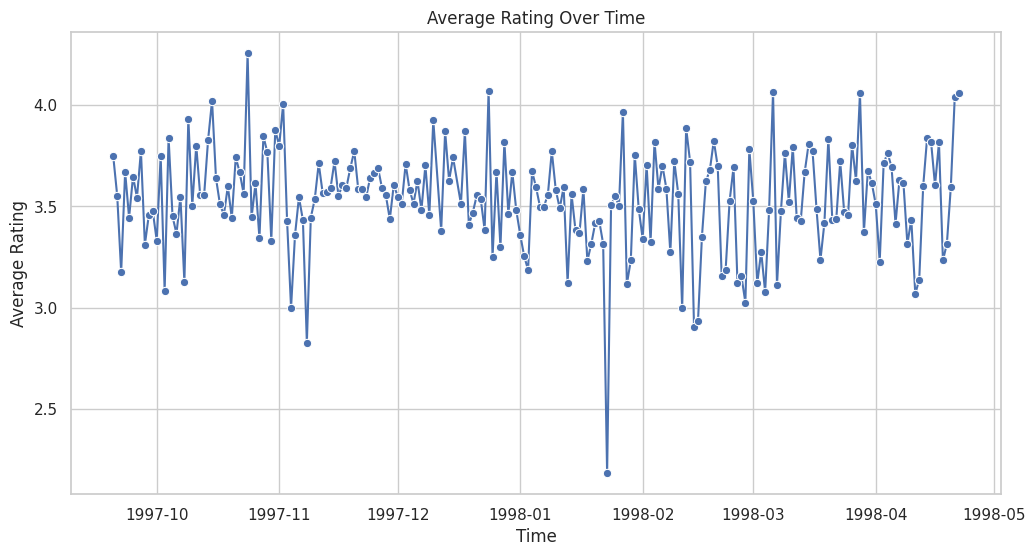

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_movie_rating():
    sns.set(style="whitegrid")

    movie_ratings = movie_rating_distribution(ratings)


    plt.figure(figsize=(12, 6))
    sns.lineplot(data=movie_ratings, x='date',y='rating', marker='o')

    plt.title('Average Rating Over Time')
    plt.xlabel('Time')
    plt.ylabel('Average Rating')


    plt.show()

plot_movie_rating()


From this graph, we can see that there is no clear trend in how our ratings evolved, at least from this graph. We also can see that, unlike our movies where the release dates are skewed, our user ratings exist within a particular time-frame. In fact, if you were to plot the counts, you could demonstrate that the counts are also generally constant over time, with a peak both near december and the beginning of April:

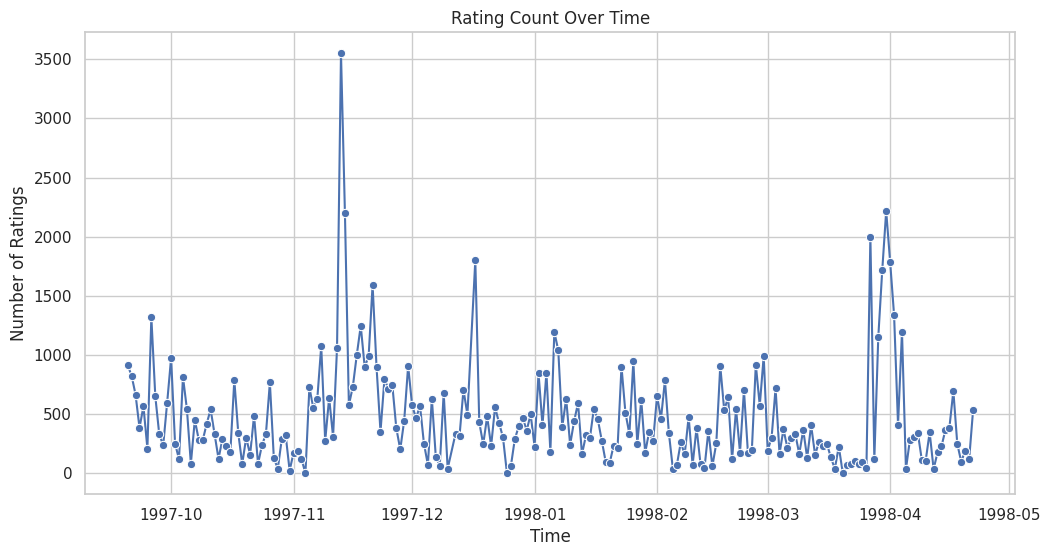

Unlike the previous graphs, which tell us some qualities that our recommender system should have ( what its rating distribution should look like, what movies are popular and thus more likely to be easier movies for our system to handle ), this graph tells us how to **split** our data. When assessing the performance of any ML model, you generally do this on unseen data. However, frequently you are given data where you do not have a clear distinction on seen versus unseern data. In this case, as we have temporal data, we can split this data based on the user rating times, assessing model performance on only the latest 10% of the data, assuming our model only has access to the past 90% of the data. As the frequency and ratings seem to relatively constant, we can have some certainty that this splitting method will result in a reasonable performance metric.

### Question 4: Seasonality-Trend Decomposition

Looking at the average rating graph another time, we can see that the data is noisy. As our ratings are ordered by time, we know from experience that it is possible for there to be weekly, monthly, or even yearly variations in performance that might obscure our true trend from our observations.

In time-series analysis, we can perform something called an additive seasonal decomposition to try to mitigate this issue. We'd like to decouple our trend ( the variation over a large time-scale ), from the seasonal information ( the variation over a smaller time-scale ), and to do so the easiest way is to simply subtract a **moving average** of the time series.

Complete the function `seasonal_decomposition` which, given the original ratings dataframe, calculate a **rolling average** and a **seasonal decomposition** of the rating data aggregated by days. Here, the rolling average is calculated by doing the following:

1. For each timestep, consider the `window_size` previous data, including the current timestep, and take the average of this data.
1. Replace this data as the true value of the data accordingly.

 Note that this **seasonal decomposition** is simply the original dataframe minus the rolling average. This will be the seasonal part of your time series, consisting of the periodic variations present within this time-frame.


As an example, your residuals should be similar to the following:
```
1997-09-20	0.000000
1997-09-21	-0.096860
1997-09-22	-0.315941
1997-09-23	0.134526
1997-09-24	-0.072983
```

**Notes**:
1. Use [`pd.DataFrame.rolling`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) for moving average calculations.
1. When calculating the rolling mean, if the `window_size` is larger than the number of previous time-steps, take the maximum number possible and aggregate accordingly.
1. Be careful to not overwrite the original review dataframe.

In [14]:
def decompose_time_series(ratings, window=7):
    """
    Perform a seasonality decomposition on a time series.

    args:
        ratings (pd.DataFrame): Original Ratings Dataframe

    return:
        (df1, df2)  Tuple(pd.DataFrame, pd.DataFrame): A tuple where df1 corresponds to the moving average, and df2 corresponds to the original dataset minus the moving average.
    """
    # Generate a time series of movie ratings using the movie_rating_distribution function.
    movie_ratings = movie_rating_distribution(ratings)
    
    # Calculate the moving average with the specified window size.
    # TODO: Use the appropriate pandas method to calculate the rolling mean.  Added in min_periods so that rows 1 through 6 still return values
    rolling_mean = movie_ratings[['rating']].rolling(window=window, min_periods=1).mean()
    
    # Calculate the residuals by subtracting the moving average from the original ratings.
    # TODO: Replace the ellipses with the appropriate subtraction operation.
    residuals = movie_ratings[['rating']] - rolling_mean

    # Return the moving average and residuals as a tuple.
    return (rolling_mean, residuals)

In [15]:
#local test
def test_decompose_time_series():
    rolling_mean, residuals = decompose_time_series(ratings)

    assert rolling_mean.shape == (213,1), rolling_mean.shape
    assert rolling_mean['rating'][0] == 3.746448087431694, rolling_mean['rating'][0]
    assert rolling_mean['rating'][100] == 3.5226506983710695, rolling_mean['rating'][100]

    assert residuals.shape == (213,1), residuals.shape
    assert residuals['rating'][0] == 0, residuals['rating'][0]
    assert residuals['rating'][100] == -0.04065069837106927, residuals['rating'][100]
    print("All tests passed!")


test_decompose_time_series()

All tests passed!


/tmp/ipykernel_29905/2075854378.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert rolling_mean['rating'][0] == 3.746448087431694, rolling_mean['rating'][0]
/tmp/ipykernel_29905/2075854378.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert rolling_mean['rating'][100] == 3.5226506983710695, rolling_mean['rating'][100]
/tmp/ipykernel_29905/2075854378.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert residuals

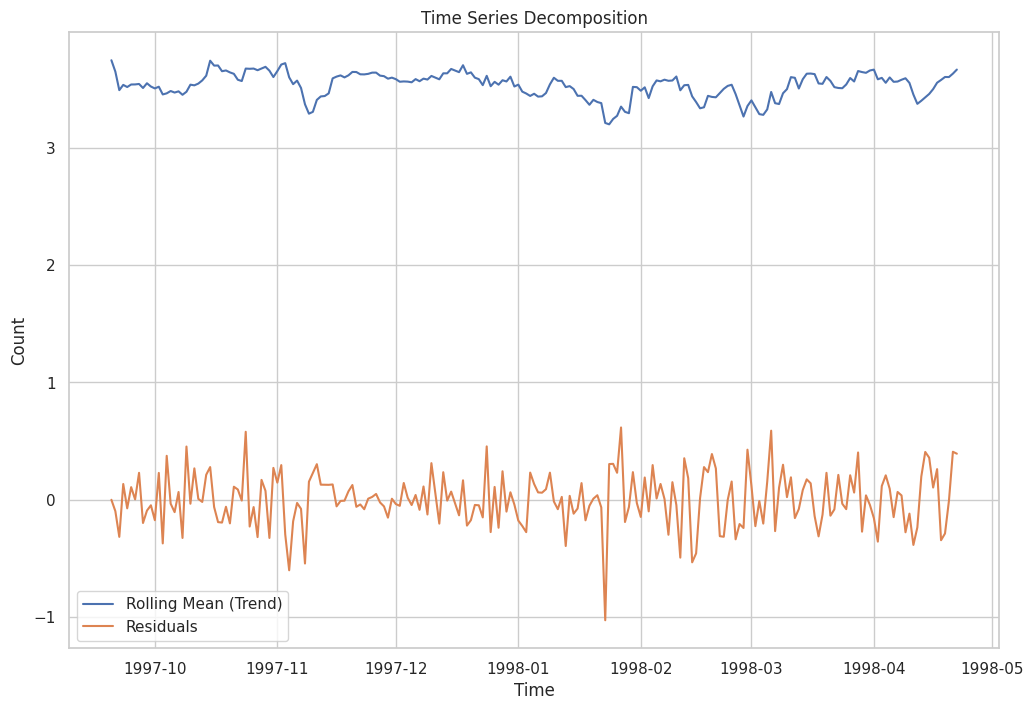

In [16]:
# Assuming you have a DataFrame 'df' with a datetime index and a numeric column 'count'
# Replace this with your actual DataFrame and column names

# Ensure your DataFrame has a datetime index
rolling_mean, residuals = decompose_time_series(ratings)

# Plot the original data, rolling mean, and residuals
plt.figure(figsize=(12, 8))
#plt.plot(df.index, df['rating'], label='Original Data')
plt.plot(rolling_mean.index, rolling_mean, label='Rolling Mean (Trend)')
plt.plot(residuals.index, residuals, label='Residuals')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Time Series Decomposition')
plt.show()

We can see that this decomposition successfully pulled out a large amount of seasonal variation. However, we can see that there's no trend in user-review over time.

### Question 5: Best and worst movies

Let's now look at which movies have the highest or lowest ratings. For simplicity, if a movie is rated multiple times, we consider the average of these ratings as the *rating score* for that movie. To ensure that the rating scores are robust, in this question we only consider movies that have more than 50 ratings.

Complete the function `best_worst_movies` which returns two lists -- one containing the movie ids of the movies with the highest average rating scores, and one with lowest average rating scores.

**Notes**:
1. The list for best movies should contain movies sorted in decreasing order of average rating
2. The list for worst movies should contain movies sorted in increasing order of average rating
3. Make sure you are using the threshold parameter correctly, as specified in the docstring.

In [17]:
def best_worst_movies(ratings, threshold = 50, size = 10):
    """
    Get the top movies with highest average ratings and top movies with lowest average ratings

    args:
        ratings (pd.DataFrame)  : Dataframe containing user ratings

    kwargs:
        threshold (int) : movies that are considered should have more ratings than this threshold
        size (int) : the number of movies with lowest / highest average ratings to get

    return: Tuple (best_movie_ids, worst_movie_ids)
            best_movie_ids (List[int])  : a list of ids for movies with the highest average ratings, sorted from highest to lowest average rating.
            worst_movie_ids [List[int]] : a list of ids for movies with the lowest average ratings, sorted from lowest to highest average rating.
    """
    #Sort the original dataframe by item_id (Movies)
    df_sorted = ratings.sort_values("item_id")
    
    #Count the number of time a movie is reviewed (and create a dataframe)
    counts = df_sorted["item_id"].value_counts()
    counts_df = counts.reset_index(name="count")
    counts_df.columns = ["item_id", "count"]
    counts_sorted = counts_df.sort_values("count")

    #Drop all movies with a lower review count than the threshold
    valid_values = counts_sorted[counts_sorted['count'] > threshold].dropna()

    #Filter the initial dataframe with the remaining movies
    filtered_df = ratings[ratings["item_id"].isin(valid_values["item_id"])].sort_values("item_id")

    #Group by remaining movies and get the mean of the ratings
    mean_ratings_df = ( filtered_df .groupby("item_id") .agg(mean_rating=("rating", "mean")) )

    #Sort by ascending or descending ratings, get a list based on the size of the input parameter "size"
    best_movie_ids = mean_ratings_df.sort_values("mean_rating", ascending=False).head(size).index.tolist()
    worst_movie_ids = mean_ratings_df.sort_values("mean_rating", ascending=True).head(size).index.tolist()
    return (best_movie_ids, worst_movie_ids)

test = best_worst_movies(ratings)

In [18]:
# local test
def test_best_worst_movies():
    best_movie_ids, worst_movie_ids = best_worst_movies(ratings)
    assert isinstance(best_movie_ids, list) and isinstance(worst_movie_ids, list)
    assert len(best_movie_ids) == len(worst_movie_ids) == 10
    assert best_movie_ids[0] == 408
    assert worst_movie_ids[0] == 931
    print("All tests passed!")

test_best_worst_movies()

All tests passed!


Now let's visualize the rating distribution for the best movie and the worst movie:

Best rated movie: Close Shave, A (1995)
Worst rated movie: Island of Dr. Moreau, The (1996)


<Axes: xlabel='item_id', ylabel='rating'>

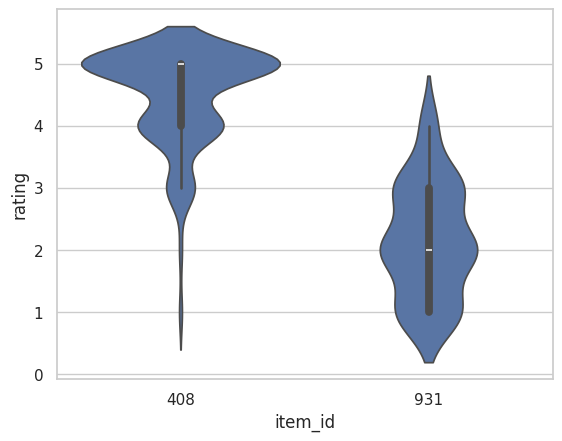

In [19]:
def plot_best_worst_rating_distribution(movies, ratings, best_movie_ids, worst_movie_ids):
    best_movie_id, worst_movie_id = best_movie_ids[0], worst_movie_ids[0]
    best_worst_ratings = ratings[ratings.item_id.isin([best_movie_id, worst_movie_id])]
    print(f'Best rated movie: {movies.loc[best_movie_id].movie_title}')
    print(f'Worst rated movie: {movies.loc[worst_movie_id].movie_title}')
    return sns.violinplot(x="item_id", y="rating", data=best_worst_ratings)

plot_best_worst_rating_distribution(movies, ratings, *best_worst_movies(ratings))

We see that there is a stark difference between the ratings for best movies (which are clustered around the top scores) and the ratings for worst movies (which are clustered around the bottom scores).

## Part B: Movie Recommendation Using Collaborative Filtering
---


Product recommendation is a major business avenue for many companies like Amazon, Netflix, IMDB, etc. Collaborative Filtering is the driving force behind this application. In this project, we will apply this algorithm to recommend new movies to users.

Most collaborative filtering algorithms fit into one of three categories:

*   User-user similarity approach
*   Item-item similarity approach
*   Matrix factorization approach

We will implement each of these techniques in this project. As a first step, in order to implement collaborative filtering, we first represent the data in a format suitable for the algorithm to work with, i.e., a format that enables easy manipulation and efficient computation within the algorithm framework.

### Question 6: Data representation

We can represent the user ratings in a matrix $X \in \mathbb{R}^{ m \times n}$ for a dataset consisting of **m users** and **n movies** such that:
* $X_{ij}$ is the rating given by the `i`-th user to the `j`-th movie (note that the user/movie ids **may not** be consecutive integer values, so the `k`-th user/movie simply refers to the one with the `k`-th smallest id).
* If a user has not rated a movie, then the corresponding entry in the matrix should be 0.
* If a user has rated a movie several times, then we take the **maximum rating value**.

Complete the function `matrix_data` which takes in the `ratings` DataFrame and returns:
1. The user-movie rating matrix `X`
2. The mean user rating matrix `user_means`, which contains the average rating of every user.
3. The mean movie rating matrix `movie_means`, which contains the average rating for every movie.

As an example, the user-movie rating matrix `X` may look like `X = [[0,3], [0,1], [2,3]]` (where the 0 entries indicate that user 1 and 2 have not rated movie 1). The corresponding `user_means` is then `[3, 1, 2.5]` and the corresponding `movie_means` is `[2, 7/3]`.

**Notes**:
* The rating matrix `X` should have integer data type, not float.
* The mean user and movie ratings should be computed only over the observed (i.e., non-zero) entries.
* Refer to the Pandas primer to see how you may convert a dataframe from wide to long format or vice versa.


In [20]:
def matrix_data(ratings):
    """
    Represent the user-movie ratings data in a matrix format

    args:
        ratings (pd.DataFrame)  : raw ratings data represented in a pandas DataFrame

    return :
        Tuple[X, user_means, movie_means]
            X (np.array[num_users, num_movies]) : the actual ratings matrix
            user_means (np.array[num_users, ])  : mean user rating array over the observed ratings
            movie_means (np.array[num_movies, ])  : mean movie rating array over the observed ratings
    """
    # Create a pivot table to represent user-item ratings with users as rows and items as columns.
    user_ratings_df = ratings.pivot_table(
        index='user_id',
        columns='item_id',
        values='rating',
        aggfunc='max',
        fill_value=0
    )
    
    # Calculate the mean ratings for each user, excluding zeros.
    non_zero_user_ratings = user_ratings_df[user_ratings_df != 0]
    user_means = non_zero_user_ratings.agg('mean', axis = 1).to_numpy()

    # Calculate the mean ratings for each movie, excluding zeros.
    movie_means = non_zero_user_ratings.agg('mean').to_numpy()

    # Return the ratings matrix, user means, and movie means as a tuple.
    return user_ratings_df.to_numpy(), user_means, movie_means


In [21]:
# local test
def test_matrix_data():
    X, user_means, movie_means = matrix_data(ratings)
    assert X.shape == (943, 1682)
    assert X.dtype == np.int64
    assert user_means.shape == (943,)
    assert movie_means.shape == (1682,)
    assert np.array_equal(X[5,:10], np.array([4, 0, 0, 0, 0, 0, 2, 4, 4, 0]))
    assert np.allclose(movie_means[0], 3.8783185840707963)
    assert np.allclose(user_means[0], 3.610294117647059)
    print("All tests passed!")

test_matrix_data()

All tests passed!


Our next step is to get the similarity weights. Let's go ahead and implement the cosine similarity function:

### Question 7: Cosine similarity

The Cosine similarity between *user i* and *user k* is the weight

$$W_{ik}=\frac{\sum_{j = 1}^{n}X_{ij} X_{kj}}{\sqrt{\sum_{j = 1}^{n}{X_{ij}}^2}\sqrt{\sum_{j = 1}^{n}{X_{kj}}^2}}.$$

Complete the `cosine_similarity` function which takes in ratings matrix `X` and returns the user-user similarity matrix `W` using cosine similarity.

**Note**:
* Avoid using for loops. `np.outer` may be helpful here.
* Refer to the [Recommender System primer](https://nbviewer.jupyter.org/url/clouddatascience.blob.core.windows.net/primers/recommender-system-primer/recommender_system_primer.ipynb) for an example of this computation.

In [22]:
def cosine_similarity(X):
    """
        Compute the user-user cosine-similarity matrix.

    args:
        X (np.array[num_users, num_movies]) : the user-movie rating matrix

    return:
        np.array[num_users, num_users]  : the cosine-similarity matrix
    """
    # Compute the L2 norm (magnitude) of each user's rating vector.
    # The norm is calculated as the square root of the sum of the squares of each user's ratings.
    X_norm = ((X**2).sum(axis=1))**0.5 
    

    # Calculate the cosine similarity matrix.
    # The similarity is computed as the dot product of user vectors divided by the product of their norms.
    # TODO: Replace the ellipses with the appropriate variables (e.g., norms for normalization).
    W_cosine = (X @ X.T) / np.outer(X_norm, X_norm)

    # Return the computed cosine similarity matrix.
    return W_cosine


In [23]:
# local test
def test_cosine_similarity():
    X = np.array([[0, 3], [0, 1], [2, 3]])
    W_user_cosine = cosine_similarity(X)
    assert W_user_cosine.shape == (3, 3)
    assert np.allclose(W_user_cosine[0, 2], 0.8320502943378437)

    X = matrix_data(ratings)[0]
    W_user_cosine = cosine_similarity(X)
    assert W_user_cosine.shape == (943, 943)
    assert np.allclose(W_user_cosine[20, 37], 0.16907916618206115)
    assert np.allclose(W_user_cosine[100, 101], 0.1537501042084208)
    print("All tests passed!")

test_cosine_similarity()

All tests passed!


### Question 8a: Predict user ratings based on user-user similarity
We are now ready to make predictions about the missing ratings:

$$\hat X_{ij} = \bar x_i + \frac{  \sum_{k=1}^m \mathbb{1}(X_{kj} \ne 0) \cdot w_{ik}(X_{kj} - \bar x_k)}{ \epsilon + \sum_{k=1}^m \mathbb{1}(X_{kj} \ne 0) \cdot |w_{ik}|}$$

Note that we add a smoothing constant $\epsilon$ in the denominator to cover the case where no user has previously rated the movie $j$. Complete the `predict_user_user` function which takes as input the rating matrix `X`, user-user similarity matrix `W` and `user_means` array; it then returns the rating prediction matrix $\hat{X}$.

**Notes**:
* To handle conditional sum, we can multiply our input matrix with some binary indicator matrix. Which binary matrix is suitable here?
* Recall that you can add a vector to every column of a matrix by broadcasting that vector to 2D.

In [29]:
def predict_user_user(X, W, user_means, eps=1e-12):
    """
    Using the user-user similarity matrix, return the predicted ratings matrix

    args:
        X (np.array[num_users, num_movies]) : the actual ratings matrix, where missing entries are 0
        W (np.array[num_users, num_users])  : user-user similarity weight matrix
        user_means (np.array[num_users, ])  : mean-user-rating array
        user_id (int)  : the id of the user whose missing ratings are predicted (from 0 to num_user)
        eps (float) : smoothing constant to avoid division by zero

    return:
        np.array[num_users,  num_movies] -- the predicted ratings matrix
    """
    # Create a binary observation matrix to indicate observed ratings.
    X_obs = (X != 0)

    # Adjust the observed ratings by subtracting user means.
    adjusted_ratings = (X - user_means[:, None]) * X_obs

    # Compute the weighted sum of adjusted ratings using the similarity matrix.
    weighted_sum = W @ adjusted_ratings

    # Compute the normalization term to account for the total weights.
    normalization_term = np.abs(W) @ X_obs + eps

    # Add back the user means to the predicted ratings.
    predicted_ratings = user_means[:, None] + (weighted_sum / normalization_term)

    # Return the predicted ratings matrix.
    return predicted_ratings


In [30]:
def test_predict_user_user():
    X = np.array([[0, 3], [0, 1], [2, 3]])
    user_means = np.array([3, 1, 2.5])
    W_user_cosine = cosine_similarity(X)
    X_predicted = predict_user_user(X, W_user_cosine, user_means)
    assert X_predicted.shape == X.shape
    assert np.allclose(X_predicted, [[2.5, 3.14689893], [0.5, 1.14689893], [2, 2.6876806]])
    print("All tests passed!")

test_predict_user_user()

All tests passed!


### Question 8b: Evaluate the prediction
To see how good our predictions $\hat X_{ij}$'s are, we can compare them with the observed ratings. Complete the function `mean_rating_diff` that computes the difference value

$$\frac{\sum_{i=1}^m \sum_{j=1}^n \mathbb{1}(X_{ij} \ne 0) \cdot (X_{ij} - \hat X_{ij})^2}{\sum_{i=1}^m \sum_{j=1}^n \mathbb{1}(X_{ij} \ne 0)},$$

where the denominator is the number of non-zero entries in $X$.

Note:

* Make sure your output is a NumPy float (with data type np.float64) instead of a regular Python float, to prevent errors.

In [33]:
def mean_rating_diff(X_true, X_pred):
    """
    Return the mean squared difference between the predicted and the actual ratings matrix.

    args:
        X_true (np.array[num_users, num_movies]) : the actual ratings matrix, where missing entries are 0
        X_pred (np.array[num_users, num_movies]) : the predicted ratings matrix

    return:
        np.float64 : mean squared difference between the predicted and the actual ratings matrix
    """
    # Create a binary observation matrix to indicate observed ratings.
    X_obs = (X_true != 0)

    # Compute the element-wise difference between the true and predicted ratings.
    rating_diff = X_true - X_pred 

    # Square the differences and apply the observation mask.
    squared_diff = (rating_diff**2) * X_obs

    # Calculate the sum of squared differences.
    sum_squared_diff = np.sum(squared_diff)

    # Normalize by the total number of observed ratings to compute the mean squared difference.
    mean_squared_diff = sum_squared_diff / np.sum(X_obs)

    # Return the mean squared difference.
    return mean_squared_diff


In [34]:
# local test
def test_mean_rating_diff():
    X = np.array([[0, 3], [0, 1], [2, 3]])
    user_means = np.array([3, 1, 2.5])
    W_user_cosine = cosine_similarity(X)
    X_pred = predict_user_user(X, W_user_cosine, user_means)
    diff = mean_rating_diff(X, X_pred)
    assert isinstance(diff, np.float64), type(diff)
    assert np.allclose(diff, 0.035175498983549575)

    X, user_means, _ = matrix_data(ratings)
    W_user_cosine = cosine_similarity(X)
    X_pred = predict_user_user(X, W_user_cosine, user_means)
    diff = mean_rating_diff(X, X_pred)
    assert isinstance(diff, np.float64)
    assert np.allclose(diff, 0.7992514466097069)

    print("All tests passed!")

test_mean_rating_diff()

All tests passed!


### Question 9: Predict user ratings based on item-item similarity
The math for item-item collaborative filtering approaches is essentially identical to the user-user case, just with the matrices transposed. To predict the likely rating for user $i$ and item $j$, we form a weighted combination of the other item ratings that user $i$ has rated, weighted by the similarity between the two items $i$ and $j$:
$$\hat X_{ij} = \bar x_j + \frac{ \sum_{k=1}^n \mathbb{1}(X_{ik} \ne 0) \cdot w_{jk}(X_{ik} - \bar x_k)}{ \epsilon + \sum_{k=1}^n \mathbb{1}(X_{ik} \ne 0) \cdot |w_{jk}|},$$


where $k$ iterates over all the items. One nice feature of this approach is that we can reuse the functions in the user-user approach as before, in addition to transposing the relevant matrices.

Complete the function `predict_item_item` which takes as input the rating matrix `X`, item-item similarity matrix `W` and `item_means` array. It then returns the ratings prediction matrix $\hat{X}$.

In [ ]:
def predict_item_item(X, W, item_means, eps=1e-12):
    """
    Using the item-item similarity matrix, return the predicted ratings matrix.

    args:
        X (np.array[num_users, num_movies]) : the actual ratings matrix
        W (np.array[num_movies, num_movies]) : movie-movie similarity weight matrix
        item_means (np.array[num_movies, ]) : mean-movie-rating array
        eps (float) : smoothing constant to avoid division by zero

    return:
        np.array[num_users, num_movies] : the predicted ratings matrix
    """
    X_pred_T = predict_user_user(X.T, W, item_means, eps)
    X_pred = X_pred_T.T
    return X_pred


In [40]:
# local test
def test_predict_item_item():
    X = np.array([[0, 3], [0, 1], [2, 3]])
    item_means = np.array([2, 7/3])
    W_item_cosine = cosine_similarity(X.T)
    X_predicted = predict_item_item(X, W_item_cosine, item_means)
    assert X_predicted.shape == X.shape
    assert np.allclose(X_predicted, [[2.66666667, 3], [0.66666667, 1], [2.27177979, 2.72822021]])
    print("All tests passed!")

test_predict_item_item()

All tests passed!


## Sparse Representation:
Until now, we have been working with a ratings matrix $X$ with shape $943\times1682$. In practical recommender systems, the data size is usually much larger where our *dense matrix* approach will overburden the system both in computation and storage.

Therefore, we have to identify a more efficient data representation to tackle this problem. One solution is to use **sparse matrices**. We notice that most entries in the ratings matrix are 0 because every user only rates a very small subset of all movies. We can leverage this observation to only store the non-zero entries of the matrix in a form known as "sparse" form, which is supported by the `scipy.sparse` library.


### Running Matrix Factorization

We start by implementing the alternating least square (ALS) algorithm for matrix factorization:
1. Initialize $U \in \mathbb{R}^{m \times k}$ and $V \in \mathbb{R}^{k \times n}$ with values distributed normally. Here $m$ is the number of users, $n$ is the number of movies, and $k$ is the input number of features.
2. Repeat `n_iters` times:
    * Update the columns of $V$:
    $$v_{j} := \left(\lambda I + \sum_{X_{ij} \ne 0} u_i u_i^T \right)^{-1} \left( \sum_{X_{ij} \ne 0} u_i X_{ij} \right), \quad j = 1, \ldots, n$$
    * Update the rows of $U$:
    $$u_{i} := \left(\lambda I + \sum_{X_{ij} \ne 0} v_j v_j^T \right)^{-1} \left( \sum_{X_{ij} \ne 0} v_j^T X_{ij} \right), \quad i = 1, \ldots, m$$

**Notes**:
* $U$ and $V$ should be initialized with `np.random.normal` where `loc = 0` and `scale = 0.1` ($U$ is initialized before $V$).
* The notation $\sum_{X_{ij} \ne 0} u_i u_i^T$ is shorthand for $\sum_{i=1}^m \mathbb{1}(X_{ij} \ne 0) \times u_i u_i^T$.
* To avoid singularity issues with inverting matrices, when computing $A^{-1}B$ we use `la.solve(A + lam * I, B)`, where `I` is the identity matrix with the same shape as `A` and `lam` is the smoothing parameter.
* For simplicity, we update each row $v_j$ and each column $u_i$ individually, i.e., we don't need to derive a matrix formula that yields the entire new $U$ or $V$ at once (though we still use matrix operations to compute the $u_i$'s and $v_j$'s).

In [ ]:
def low_rank_matrix_factorization(X_sparse, k, niters=5, lam=10., seed = 0):
    """
    Factor a rating matrix into user-features and movie-features.

    args:
        X_sparse (sp.coo_matrix[num_users, num_movies]) : the ratings matrix, assumed sparse in COO format
        k (int) : the number of features in the lower-rank matrices U and V
        niters (int) : number of iterations to run
        lam (float) : regularization parameter, shown as lambda
        seed (int) : the seed for numpy random generator

    return : Tuple(U, V)
        U : np.array[num_users,  k] -- the user-feature matrix
        V : np.array[k, num_movies] -- the movie-feature matrix
    """
    np.random.seed(seed)
    U = np.random.normal(scale = 0.1, size = (X_sparse.shape[0],k))
    V = np.random.normal(scale = 0.1, size = ((k, X_sparse.shape[1])))
    X_csc, X_csr = X_sparse.tocsc(), X_sparse.tocsr()
    smooth = lam*np.eye(k)

    for _ in range(niters):
        B = X_sparse.T @ U
        for j in range(V.shape[1]):
            U_mask = U[X_csc.getcol(j).indices]
            A = U_mask.T @ U_mask
            V[:,j] = la.solve(A + smooth, B[j])

        B = X_sparse @ V.T
        for i in range(U.shape[0]):
            V_mask = V[:,X_csr.getrow(i).indices]
            A = V_mask @ V_mask.T
            U[i] = la.solve(A + smooth, B[i])

    return U, V

In [ ]:
# local test
def test_low_rank_matrix_factorization():
    X_check = sp.coo_matrix([[5., 0., 0.], [1., 1., 0.]])
    U_check, V_check = low_rank_matrix_factorization(X_check, 3)
    assert np.allclose([
        [2.52975137e-04, 8.88862671e-05, 8.88927380e-05],
        [5.26156164e-05, 1.84872240e-05, 1.84885459e-05],
    ], U_check), U_check
    assert np.allclose([
        [5.05950291e-04, 1.77772540e-04, 1.77785482e-04],
        [2.02058899e-05, 7.09970620e-06, 7.09998333e-06],
        [0, 0, 0]
    ], V_check.T), V_check.T
    print("All tests passed!")

test_low_rank_matrix_factorization()

### Make recommendations

With $U$ and $V$, we can now compute the predicted ratings $\hat X = UV$. For each user $u_i$, let's recommend the movie with the highest predicted rating that the user has not rated before:

$$r_i = 1 + \underset{j}{\operatorname{argmax}} \left(\mathbb{1}(X_{ij} = 0) \times \hat X_{ij} \right).$$

The function `recommend` returns a list of recommended movie ids, one for each user.

**Note**:
* The actual movie ids are numbered starting at 1 and not 0 in the original `ratings` dataframe. In other words, if we recommend a movie at column index $j$ in $X$, its movie id is $j+1$. This is why there is a 1 added to the argmax above.

In [ ]:
def recommend_mf(X_sparse, U, V):
    """
    Recommend a new movie for every user.

    args:
        X_sparse (sp.coo_matrix[num_users, num_movies]) : the ratings matrix
        U (np.array[num_users, num_features]) : a matrix of features for each user
        V (np.array[num_features, num_movies]) : a matrix of features for each movie

    return:
        List[int] -- a list of ids of recommended movie, one for each user
    """
    X_hat = sp.coo_matrix(
        ([-np.inf] * X_sparse.data.shape[0], (X_sparse.row, X_sparse.col)),
        shape = X_sparse.shape
    ) + (U @ V)
    return list(np.asarray(X_hat.argmax(axis = 1)).squeeze() + 1)

In [ ]:
# local test
def test_recommend_mf():
    U = np.array([[1., 1., 0., 0.], [0., 1., 0., 1.]])
    V = np.array([[.5, 0., 0., .5], [0., .5, .5, 0.], [.5, -1., .5, 3.]]).T
    X = sp.coo_matrix([[5., 0., 0.], [1., 1., 0.]])
    recommendation = recommend_mf(X, U, V)
    assert recommendation == [2, 3]
    print("All tests passed!")

test_recommend_mf()

Now let's bring everything together: we will compute the predicted ratings matrix using the three approaches implemented above, evaluate their mean squared differences to the observed ratings, and see how the recommendations differ across these approaches. What do you observe about the mean squared rating errors of the three approaches? What about the most frequently recommended movies in each approach? How do the distributions of the predicted ratings differ from the true average ratings you calculated before, and what might that say about each system as a whole?

In [ ]:
# this cell has been tagged with excluded_from_script
# it will not be run by the autograder
from collections import Counter

def recommend_user_user_item_item(X, X_pred, size = 10):
    X_hat_remove_observed = np.where(X != 0, -np.inf, X_pred)
    return (X_hat_remove_observed.argmax(axis = 1) + 1).tolist()

def most_recommended_movies(recommended_movie_ids, size = 10):
    counts = Counter(recommended_movie_ids)
    return [(movies.loc[m_id].movie_title, count) for m_id, count in counts.most_common(size)]

def compare_cf_approaches():
    X, user_means, item_means = matrix_data(ratings)

    # user-user approach
    W_user_cosine = cosine_similarity(X)
    X_pred_user_user = predict_user_user(X, W_user_cosine, user_means)

    average_across_rows = np.mean(X_pred_user_user, axis=1)
    plt.hist(average_across_rows, bins=20, edgecolor='black')
    plt.title('Histogram of Average User Rating for User-User Similarity')
    plt.xlabel('Average User Rating')
    plt.show()


    # item-item approach
    W_item_cosine = cosine_similarity(X.T)
    X_pred_item_item = predict_item_item(X, W_item_cosine, item_means)

    average_across_rows = np.mean(X_pred_item_item, axis=1)
    plt.hist(average_across_rows, bins=20, edgecolor='black')
    plt.title('Histogram of Average User Rating for Item-Item Similarity')
    plt.xlabel('Average User Rating')
    plt.show()

    # matrix-factorization approach
    X_sparse = sp.coo_matrix(X)
    U, V = low_rank_matrix_factorization(X_sparse, 10, 15)
    X_pred_mf = U @ V


    average_across_rows = np.mean(X_pred_mf, axis=1)
    plt.hist(average_across_rows, bins=20, edgecolor='black')
    plt.title('Histogram of Average User Rating for Matrix Factorization')
    plt.xlabel('Average User Rating')
    plt.show()

    print("The mean squared error of the predicted ratings in the item-item approach is", mean_rating_diff(X, X_pred_item_item))
    print("The top 10 most frequently recommended movies in the user-user approach is")
    print(most_recommended_movies(recommend_user_user_item_item(X, X_pred_item_item)))
    print("The mean squared error of the predicted ratings in the matrix factorization approach is", mean_rating_diff(X, X_pred_mf))
    print("The top 10 most frequently recommended movies in the user-user approach is")
    print(most_recommended_movies(recommend_mf(X_sparse, U, V)))
    print("The mean squared error of the predicted ratings in the user-user approach is", mean_rating_diff(X, X_pred_user_user))
    print("The top 10 most frequently recommended movies in the user-user approach is")
    print(most_recommended_movies(recommend_user_user_item_item(X, X_pred_user_user)))


compare_cf_approaches()

You might notice that the Average User Rating Plot for Matrix Factorization is substantially lower, yet the Matrix Factorization seems to have a better performance compared to RMSE. What could cause that to happen?